<a href="https://colab.research.google.com/github/joony0512/Deep_Learning_Class/blob/main/Part10/P10_CH01_03.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# MobileNetV3을 이용한 Image Classification 구현 및 성능 개선


## Data 소개
- 이번 주제는 Intel image classification dataset을 사용합니다.
- Intel image classification dataset은 buildings, forest, mountains, glacier, sea, street 6개의 class로 구성되어 있습니다.
- 파일은 하나의 압축파일로 구성되며 압축파일은 다음과 같이 구성되어 있습니다.
- 모든 데이터는 각 class 이름에 해당되는 directory 아래에 있습니다.    

1. seg_train
  - training용 data

2. seg_test
  - validation용 data로 사용
  - label 있음
  

3. set_pred
  - test용 data
  - label 없음
  - 미사용

원본 데이터 출처 https://www.kaggle.com/datasets/puneet6060/intel-image-classification
  

In [1]:
import os
import numpy as np
import random
from datetime import datetime
import time
import math
import gdown
import matplotlib.pyplot as plt


import tensorflow as tf
from tensorflow import keras
from keras.applications import *
from keras.layers import Conv2D, ReLU, MaxPooling2D, Dense, BatchNormalization, GlobalAveragePooling2D, Softmax

AUTOTUNE = tf.data.AUTOTUNE

In [2]:
## Hyper Parameter 설정

# image resolution
RES = 224

# class 수
N_CLASS = 6

# Batch Size
N_BATCH = 64

# Epoch 수
N_EPOCH = 50

# Learning rate
LR = 0.0001

# 1. Data Download / Preprocessing

## Data 불러오기

In [3]:
data_url = 'https://drive.google.com/uc?id=1bDyPlWP3AczXJbBmmjSGuAJXY7R_IjeJ'

In [4]:
gdown.download(data_url, 'intel_image_classification.tar', quiet=False)

Downloading...
From: https://drive.google.com/uc?id=1bDyPlWP3AczXJbBmmjSGuAJXY7R_IjeJ
To: /content/intel_image_classification.tar
100%|██████████| 388M/388M [00:05<00:00, 65.5MB/s]


'intel_image_classification.tar'

In [5]:
!tar -xf intel_image_classification.tar

In [7]:
data_dir = "."
train_dir = os.path.join(data_dir, 'seg_train', 'seg_train')
val_dir = os.path.join(data_dir, 'seg_test', 'seg_test')

In [8]:
!ls $train_dir

buildings  forest  glacier  mountain  sea  street


## Dataset 만들기


In [9]:
train_ds = keras.preprocessing.image_dataset_from_directory(
    train_dir,
    image_size=(RES, RES),
    batch_size=N_BATCH,
    shuffle = True
    )

val_ds = keras.preprocessing.image_dataset_from_directory(
    val_dir,
    image_size=(RES, RES),
    batch_size=N_BATCH,
    shuffle = False
    )

Found 14034 files belonging to 6 classes.
Found 3000 files belonging to 6 classes.


## 데이터 개수 확인

In [10]:
N_TRAIN = 14034
N_VAL = 3000

## Class list 만들기

In [11]:
# classes = ['buildings', 'forest', 'mountains', 'glacier', 'sea', 'street']
classes = train_ds.class_names
print(classes)

['buildings', 'forest', 'glacier', 'mountain', 'sea', 'street']


In [12]:
train_ds = train_ds.prefetch(AUTOTUNE)
val_ds = val_ds.prefetch(AUTOTUNE)

## Dataset 확인하기

images.shape (64, 224, 224, 3)
labels.shape (64,)
images.dtype <dtype: 'float32'>
labels.dtype <dtype: 'int32'>


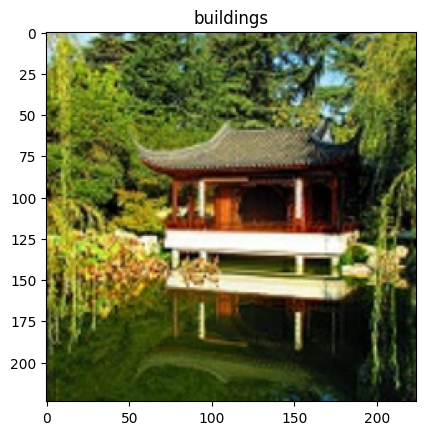

In [13]:
for images, labels in train_ds.take(1):
    print('images.shape', images.shape)
    print('labels.shape', labels.shape)
    print('images.dtype', images.dtype)
    print('labels.dtype', labels.dtype)
    plt.imshow(images[0].numpy().astype('uint8'))
    plt.title(classes[labels[0].numpy()])
    plt.show( )

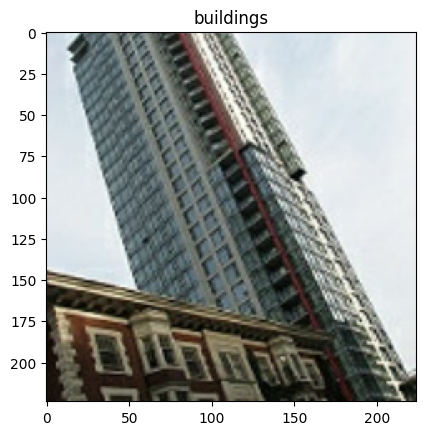

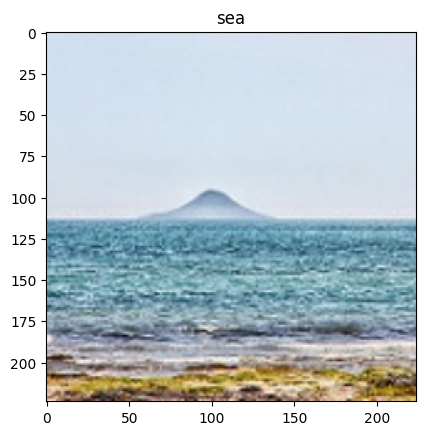

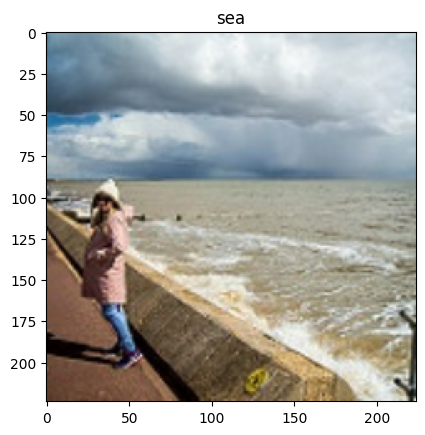

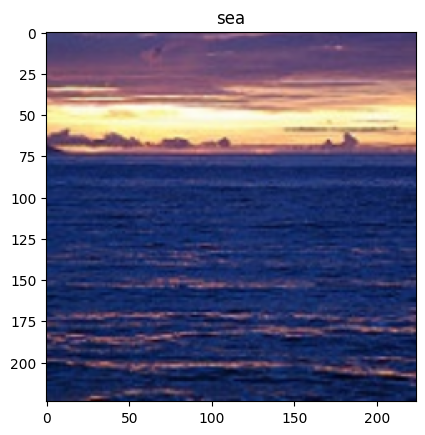

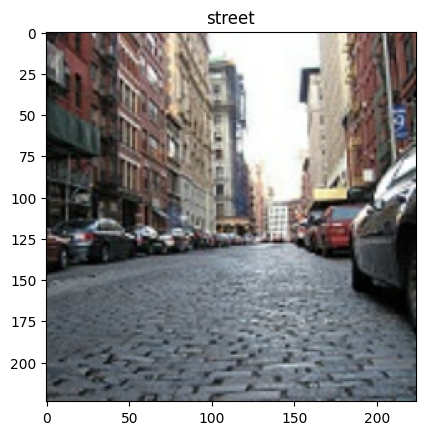

In [14]:
for images, labels in train_ds.take(5):
    plt.imshow(images[0].numpy().astype("uint8"))
    plt.title(classes[labels[0].numpy()])
    plt.show( )

# 2. Pretrained MobileNetV3 로 Training 하기

In [15]:
from keras.applications import MobileNetV3Small
from keras.applications.mobilenet_v3 import preprocess_input

mobilenetv3 = MobileNetV3Small(weights='imagenet', include_top=False, input_shape=(RES, RES, 3))

4334752/4334752 [==============================] - 1s 0us/step


In [16]:
mobilenetv3.summary()

Model: "MobilenetV3small"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 224, 224, 3)]        0         []                            
                                                                                                  
 rescaling (Rescaling)       (None, 224, 224, 3)          0         ['input_1[0][0]']             
                                                                                                  
 Conv (Conv2D)               (None, 112, 112, 16)         432       ['rescaling[0][0]']           
                                                                                                  
 Conv/BatchNorm (BatchNorma  (None, 112, 112, 16)         64        ['Conv[0][0]']                
 lization)                                                                         

In [17]:
def create_model():
    inputs = keras.Input(shape=(RES, RES, 3))
    x = preprocess_input(inputs)
    x = mobilenetv3(x)
    x = GlobalAveragePooling2D()(x)
    x = Dense(N_CLASS)(x)
    x = BatchNormalization()(x)
    outputs = Softmax()(x)

    model = keras.Model(inputs, outputs)
    return model

In [18]:
model = create_model()

In [19]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 MobilenetV3small (Function  (None, 7, 7, 576)         939120    
 al)                                                             
                                                                 
 global_average_pooling2d (  (None, 576)               0         
 GlobalAveragePooling2D)                                         
                                                                 
 dense (Dense)               (None, 6)                 3462      
                                                                 
 batch_normalization (Batch  (None, 6)                 24        
 Normalization)                                                  
                                                             

## 학습

In [20]:
model.compile(keras.optimizers.SGD(learning_rate=LR), loss = keras.losses.SparseCategoricalCrossentropy(), metrics = ['accuracy'])

In [21]:
model.fit(train_ds, epochs=N_EPOCH, validation_data=val_ds)

Epoch 1/50
220/220 [==============================] - 54s 143ms/step - loss: 1.8837 - accuracy: 0.2339 - val_loss: 2.0321 - val_accuracy: 0.2427
Epoch 2/50
220/220 [==============================] - 29s 130ms/step - loss: 1.6835 - accuracy: 0.3140 - val_loss: 1.8216 - val_accuracy: 0.3007
Epoch 3/50
220/220 [==============================] - 27s 123ms/step - loss: 1.5264 - accuracy: 0.3834 - val_loss: 1.6114 - val_accuracy: 0.3663
Epoch 4/50
220/220 [==============================] - 29s 130ms/step - loss: 1.4098 - accuracy: 0.4485 - val_loss: 1.4532 - val_accuracy: 0.4293
Epoch 5/50
220/220 [==============================] - 28s 125ms/step - loss: 1.3257 - accuracy: 0.4957 - val_loss: 1.3366 - val_accuracy: 0.4887
Epoch 6/50
220/220 [==============================] - 29s 131ms/step - loss: 1.2576 - accuracy: 0.5352 - val_loss: 1.2485 - val_accuracy: 0.5340
Epoch 7/50
220/220 [==============================] - 27s 122ms/step - loss: 1.2056 - accuracy: 0.5637 - val_loss: 1.1840 - val_ac

## Optimizer 변경해보기

In [24]:
model2 = create_model()
model2.compile(keras.optimizers.Adam(learning_rate=LR), loss = keras.losses.SparseCategoricalCrossentropy(), metrics = ['accuracy'])

In [25]:
model2.fit(train_ds, epochs = N_EPOCH, validation_data = val_ds)

Epoch 1/50
220/220 [==============================] - 55s 132ms/step - loss: 0.7690 - accuracy: 0.8082 - val_loss: 0.5125 - val_accuracy: 0.9057
Epoch 2/50
220/220 [==============================] - 30s 134ms/step - loss: 0.5069 - accuracy: 0.9181 - val_loss: 0.5483 - val_accuracy: 0.9147
Epoch 3/50
220/220 [==============================] - 31s 138ms/step - loss: 0.4491 - accuracy: 0.9305 - val_loss: 0.5460 - val_accuracy: 0.9187
Epoch 4/50
220/220 [==============================] - 28s 125ms/step - loss: 0.4110 - accuracy: 0.9416 - val_loss: 0.5462 - val_accuracy: 0.9183
Epoch 5/50
220/220 [==============================] - 29s 130ms/step - loss: 0.3824 - accuracy: 0.9484 - val_loss: 0.5424 - val_accuracy: 0.9097
Epoch 6/50
220/220 [==============================] - 28s 127ms/step - loss: 0.3510 - accuracy: 0.9617 - val_loss: 0.5025 - val_accuracy: 0.9230
Epoch 7/50
220/220 [==============================] - 28s 127ms/step - loss: 0.3274 - accuracy: 0.9674 - val_loss: 0.4860 - val_ac

KeyboardInterrupt: ignored

- adam의 정확도가 훨씬 높음, SGD에는 모멘텀 설정해서 성능향상가능

# 3. Model 성능올리기
- Data Augmentation
    - horizontal flip
    - random crop

In [32]:
RES_BEF = 256
N_EPOCH = 100 # data 개수 늘린 효과

In [27]:
train_ds = keras.preprocessing.image_dataset_from_directory(
    train_dir,
    shuffle = True,
    image_size = (RES_BEF, RES_BEF),
    batch_size = N_BATCH
)

Found 14034 files belonging to 6 classes.


In [28]:
# dataloade가 image, label 반환하기 때문에 augmentation단계에서도 둘다 반환
def aug(image, label):
    image = tf.image.random_crop(image, [RES, RES, 3])
    image = tf.image.random_flip_left_right(image)
    return image, label

In [29]:
# batch단위로 aug를 적용하면 배치마다 같은 적용이 되기때문에 umbatch후 적용

train_ds = train_ds.unbatch().map(aug, num_parallel_calls=AUTOTUNE).batch(N_BATCH, drop_remainder = True).prefetch(AUTOTUNE)

In [30]:
model3 = create_model()
model3.compile(keras.optimizers.Adam(learning_rate=LR), loss = keras.losses.SparseCategoricalCrossentropy(), metrics = ['accuracy'])

In [33]:
model3.fit(train_ds, epochs=N_EPOCH, validation_data = val_ds)

Epoch 1/100
219/219 [==============================] - 54s 147ms/step - loss: 0.5827 - accuracy: 0.8984 - val_loss: 0.4273 - val_accuracy: 0.9177
Epoch 2/100
219/219 [==============================] - 29s 131ms/step - loss: 0.4009 - accuracy: 0.9627 - val_loss: 0.4299 - val_accuracy: 0.9263
Epoch 3/100
219/219 [==============================] - 29s 130ms/step - loss: 0.3712 - accuracy: 0.9679 - val_loss: 0.4235 - val_accuracy: 0.9270
Epoch 4/100
219/219 [==============================] - 34s 154ms/step - loss: 0.3475 - accuracy: 0.9733 - val_loss: 0.4162 - val_accuracy: 0.9317
Epoch 5/100
219/219 [==============================] - 32s 145ms/step - loss: 0.3243 - accuracy: 0.9762 - val_loss: 0.4204 - val_accuracy: 0.9337
Epoch 6/100
219/219 [==============================] - 31s 142ms/step - loss: 0.3068 - accuracy: 0.9806 - val_loss: 0.4231 - val_accuracy: 0.9227
Epoch 7/100
219/219 [==============================] - 37s 169ms/step - loss: 0.2949 - accuracy: 0.9817 - val_loss: 0.4087 -

KeyboardInterrupt: ignored

- 약간의 정확도 향상

## 🌼 cutmix 알고리즘 구현
논문 : https://arxiv.org/abs/1905.04899
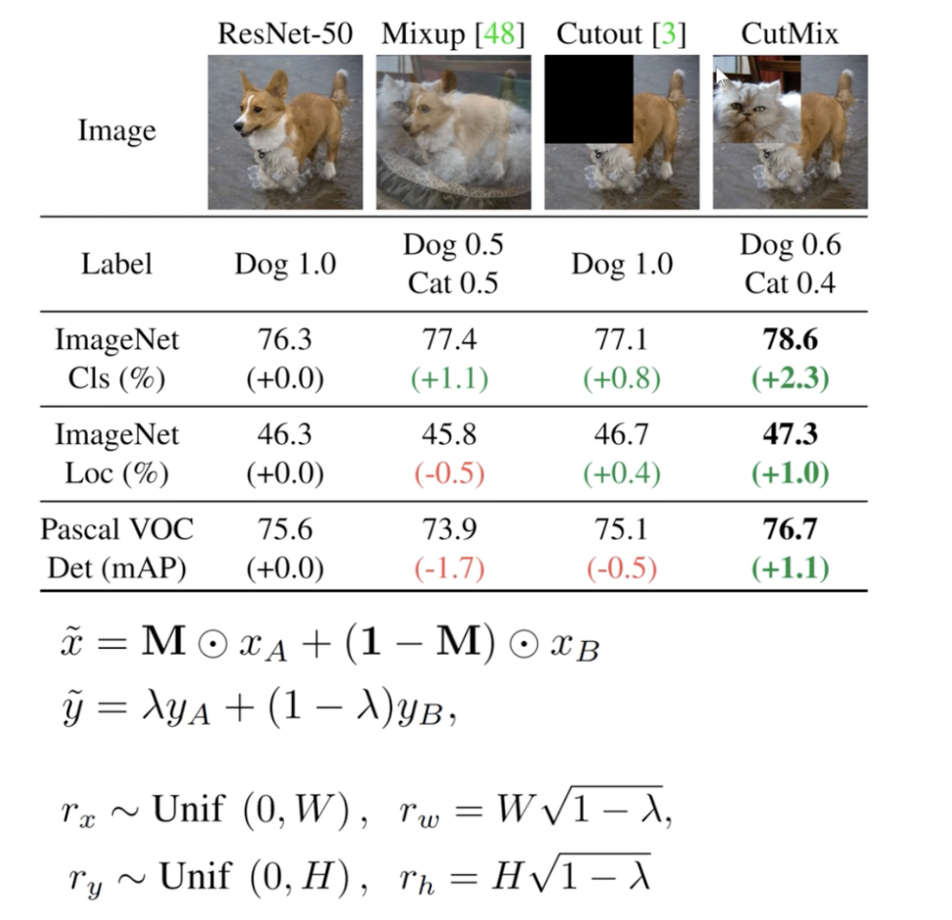

In [35]:
train_ds = keras.preprocessing.image_dataset_from_directory(
    train_dir,
    shuffle=True,
    image_size=(RES_BEF, RES_BEF),
    label_mode = 'categorical',
    batch_size=N_BATCH
)

val_ds = keras.preprocessing.image_dataset_from_directory(
    val_dir,
    shuffle=False,
    image_size=(RES, RES),
    label_mode = 'categorical',
    batch_size=N_BATCH
)



Found 14034 files belonging to 6 classes.
Found 3000 files belonging to 6 classes.


In [36]:
for images, labels in train_ds.take(1):
    print(labels[0])
for images, labels in val_ds.take(1):
    print(labels[0])


tf.Tensor([0. 0. 0. 1. 0. 0.], shape=(6,), dtype=float32)
tf.Tensor([1. 0. 0. 0. 0. 0.], shape=(6,), dtype=float32)


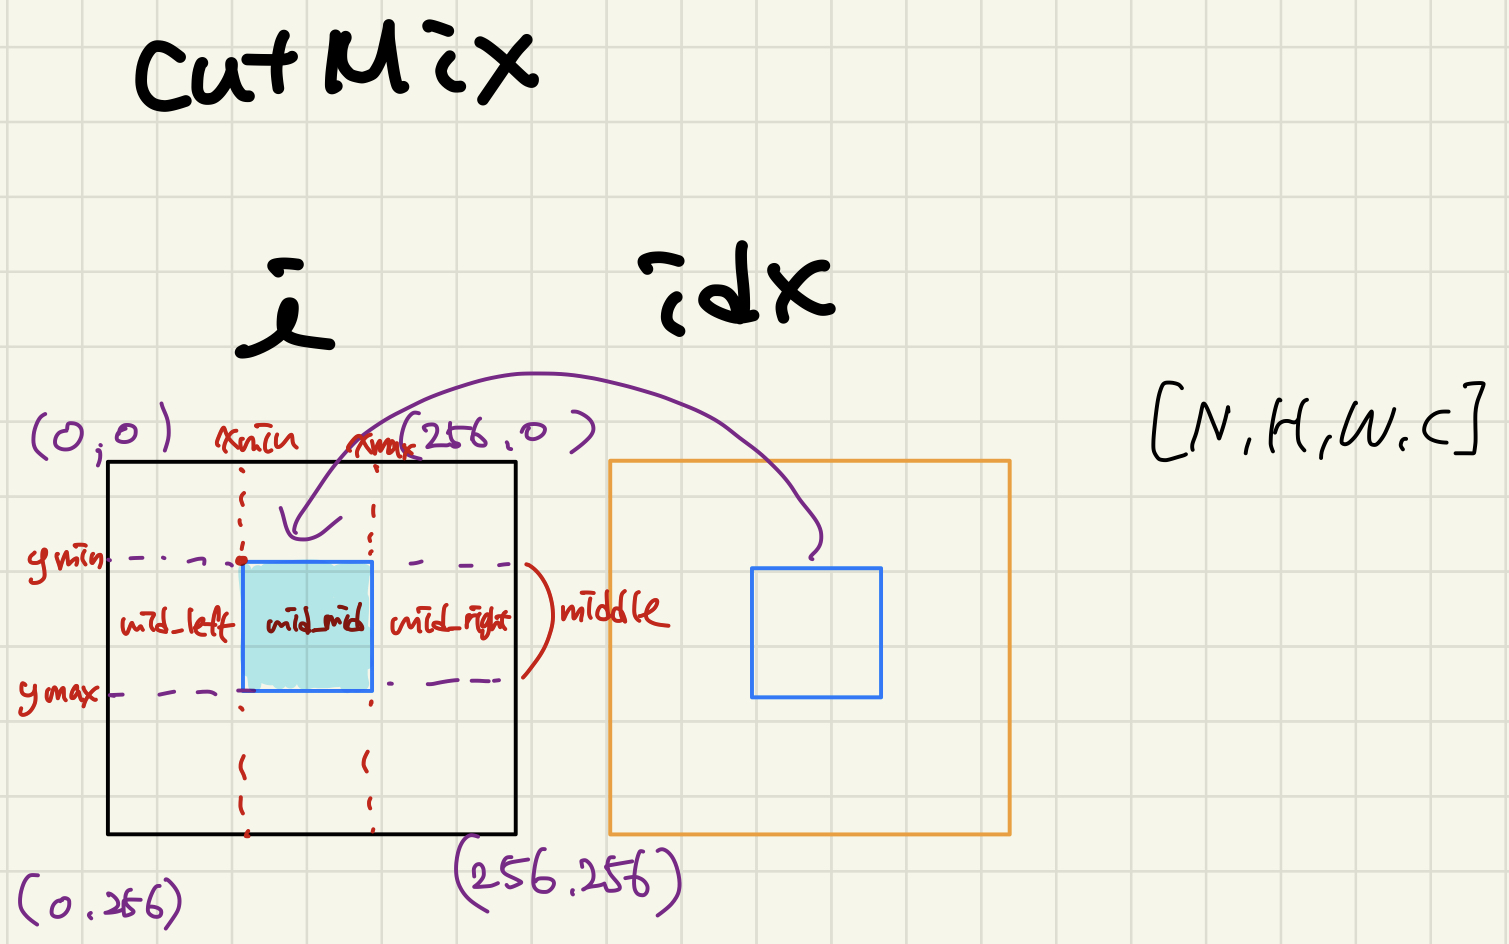

In [37]:
# cutmix 알고리즘 구현

def cutmix(images, labels):
    imgs = [] ; labs = []
    for i in range(N_BATCH):
        APPLY = tf.cast(tf.random.uniform(())>=  0.5, tf.int32) # 갖고있는 이미지 i : i번째 이미지에 대해 cutmix 적용여부 : 0, 1 (구멍내고 채우기)
        idx = tf.random.uniform((), 0, N_BATCH, dtype=tf.int32) # 구멍난 부분 채울 이미지 : 배치내에서 선택하기 : 0~63index중에서 선택

        # 1. 합성이미지 만들기 : 갖고있는 이미지 i 에 새로운 이미지 idx 결합

        W = RES
        H = RES
        lm = tf.random.uniform(())

        cut_ratio = tf.math.sqrt(1. - lm)
        cut_w = tf.cast(W * cut_ratio, tf.int32) * APPLY # 잘라질 사진의 넓이 r_w
        cut_h = tf.cast(H * cut_ratio, tf.int32) * APPLY # 잘라질 사진의 높이 r_h

        cx = tf.random.uniform((), int(W/8), int(W*7/8), dtype=tf.int32) * APPLY # 구멍을 낼 부분의 center x좌표
        cy = tf.random.uniform((), int(H/8), int(H*7/8), dtype=tf.int32) * APPLY # 구멍을 낼 부분의 center y좌표

        xmin = tf.clip_by_value(cx - cut_w // 2, 0, W)
        ymin = tf.clip_by_value(cy - cut_h // 2, 0, H)

        xmax = tf.clip_by_value(cx + cut_w // 2, 0, W)
        ymax = tf.clip_by_value(cy + cut_h // 2, 0, H)

        mid_left = images[i, ymin:ymax, :xmin, :] # N, H, W, C ->H, W, C
        mid_mid = images[idx, ymin:ymax, xmin:xmax, :] # 구멍난 부분 채울 이미지
        mid_right = images[i, ymin:ymax, xmax: , :] #  N, H, W, C ->H, W, C

        middle = tf.concat([mid_left, mid_mid, mid_right], axis=1) # H, W, C -> x축방향으로 이어 붙여야하기 때문에
        top = images[i, :ymin, :, :] # 윗부분 통째로
        bottom = images[i, ymax:, :, :] # 아랫부분 통째로

        new_img = tf.concat([top, middle, bottom], axis=0) # H, W, C -> y축방향으로 이어 붙여야하기 때문에
        imgs.append(new_img)

        # 2. 새로운 label 만들기
        ## 실제 잘린 영역의 %만큼 레이블로 반환

        cut_w_mod = xmax - xmin
        cut_h_mod = ymax - ymin

        alpha = tf.cast((cut_w_mod * cut_h_mod)/(W*H), tf.float32)

        label1 = labels[i]
        label2 = labels[idx]

        new_label = ((1-alpha)*label1 + alpha*label2)
        labs.append(new_label)
    new_imgs = tf.reshape(tf.stack(imgs), [-1, RES, RES, 3])
    new_labs = tf.reshape(tf.stack(labs), [-1, N_CLASS])

    return new_imgs, new_labs



### cutmix 적용 및 확인

In [40]:
train_ds = train_ds.unbatch().map(aug, num_parallel_calls = AUTOTUNE).batch(N_BATCH, drop_remainder=True)\
            .map(cutmix, num_parallel_calls = AUTOTUNE).prefetch(AUTOTUNE)

[0.         0.8970026  0.         0.10299745 0.         0.        ]


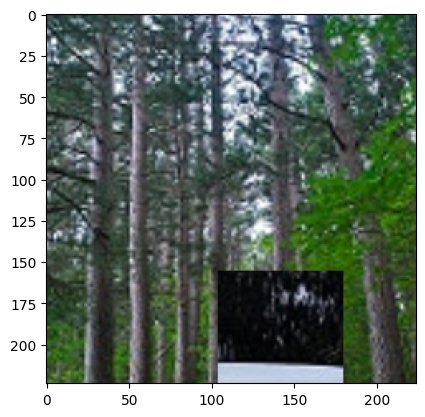

[0. 0. 1. 0. 0. 0.]


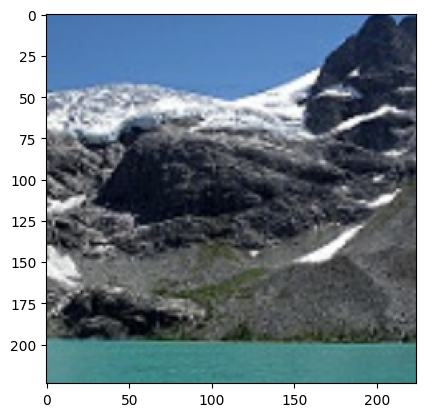

[0. 0. 1. 0. 0. 0.]


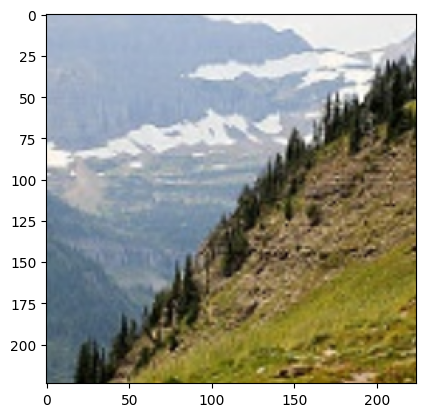

[0.         0.         0.42779416 0.         0.57220584 0.        ]


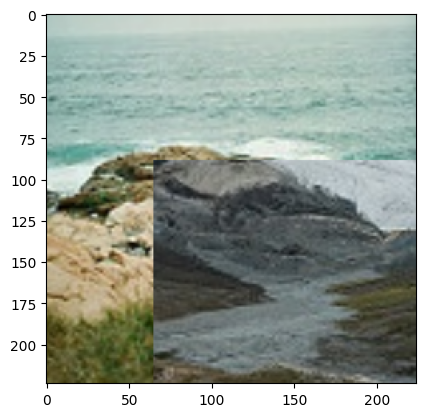

[0.         0.         0.47265625 0.         0.52734375 0.        ]


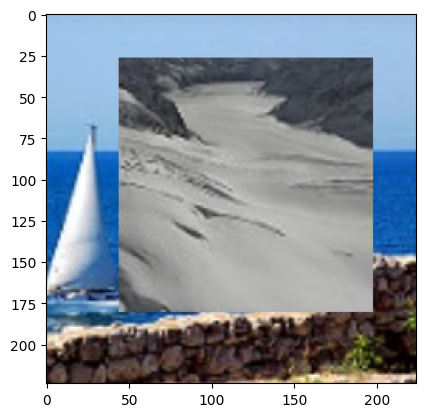

In [42]:
for images, labels in train_ds.take(5):
    plt.imshow(images[0].numpy().astype("uint8"))
    print(labels[0].numpy())
    plt.show()

### cutmix 적용하여 training

In [43]:
model = create_model()

In [44]:
model.compile(keras.optimizers.Adam(LR), loss = keras.losses.CategoricalCrossentropy(), metrics =['accuracy'])

In [46]:
model.fit(train_ds, epochs = 50, validation_data = val_ds)

Epoch 1/50
219/219 [==============================] - 119s 221ms/step - loss: 0.7864 - accuracy: 0.8374 - val_loss: 0.3517 - val_accuracy: 0.9270
Epoch 2/50
219/219 [==============================] - 57s 256ms/step - loss: 0.6569 - accuracy: 0.8827 - val_loss: 0.3626 - val_accuracy: 0.9310
Epoch 3/50
219/219 [==============================] - 43s 196ms/step - loss: 0.6342 - accuracy: 0.8888 - val_loss: 0.3397 - val_accuracy: 0.9370
Epoch 4/50
219/219 [==============================] - 38s 172ms/step - loss: 0.6169 - accuracy: 0.8940 - val_loss: 0.3569 - val_accuracy: 0.9333
Epoch 5/50
219/219 [==============================] - 41s 185ms/step - loss: 0.6007 - accuracy: 0.8939 - val_loss: 0.3327 - val_accuracy: 0.9397
Epoch 6/50
219/219 [==============================] - 41s 186ms/step - loss: 0.5905 - accuracy: 0.8969 - val_loss: 0.3420 - val_accuracy: 0.9360
Epoch 7/50
219/219 [==============================] - 39s 175ms/step - loss: 0.5840 - accuracy: 0.8911 - val_loss: 0.3411 - val_a

KeyboardInterrupt: ignored

- 일반 augmentation 적용보다 정확도가 더 상승